# Predicting Medical Appointment Cancellation and Data Exploration

The purpose of this project is to predict whether or not a appointment that has been scheduled will be cancelled in the days/months leading up to the appointment. The steps of this project is comprised of 3 sections:

**Section 1:** Clean Up

**Section 2:** Data Exploration

**Section 3:** Appointment Cancellation Prediction

## Table of Contents

* [About the Data](#AboutData)
* [Section 1: Clean-Up and Data Wrangling](#Section1)
* [Section 2: Data Exploration](#Section2)
    * [Section 2.1: Numerical Features](#Section2.1)
    * [Section 2.2: Categorical Features](#Section2.2)
* [Section 3: Model Building and Prediction](#Section3)
* [Section 4: Reflection](#Section4)

## About the data <a class="anchor" id="AboutData"></a>

This dataset contains all appointments scheduled since 2015, with all historical data on appointment types, dates, and whether or not the appointment scheduled was cancelled. A patientid has been encoded, and indicates a unique patient for every ID. The provider is also encoded with a random number, so that each number represents a different provider. 

In [1]:
# Importing the tools needed
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
sns.set_style("whitegrid")


from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

In [2]:
fc = pd.read_csv('hist_appt_report.csv')
fc.head()

,patientid,apptyear,apptmnth,apptdate,apptstarttime,apptday,apptcancelreason,apptslotstatus,appttype,apptscheduledate,...,ptnt zn 1,ptnt zn 2,ptnt zn 3,patientsex,patient age,ptnt age mnths,ptnt cnsnt t cll ysn,ptnt cnsnt t txt ysn,appt inseligibstatus,ptnt rmssn
0,NaN,2017,DECEMBER,12/4/2017,2:00 PM,Monday,NaN,o - Open Slot,Launch Visit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unverified,NaN
1,NaN,2017,DECEMBER,12/5/2017,10:30 AM,Tuesday,NaN,o - Open Slot,Launch Visit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unverified,NaN
2,NaN,2017,DECEMBER,12/5/2017,10:45 AM,Tuesday,NaN,o - Open Slot,Launch Visit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unverified,NaN
3,NaN,2017,DECEMBER,12/5/2017,11:00 AM,Tuesday,NaN,o - Open Slot,Launch Visit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unverified,NaN
4,NaN,2017,DECEMBER,12/5/2017,2:00 PM,Tuesday,NaN,o - Open Slot,Launch Visit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unverified,NaN


Information on some columns that are not as straightforward:

| Column| Description  |
|------|------|
|apptcancelreason  | if the appointment was cancelled ( indicated in'apptslotstatus')|
|apptslotstatus|whether the appointment slot was scheduled, cancelled, or open|
|appttype  | type of appointment |
|appt schdlng prvdr  | specific provider for patient, encoded by a number|
|ptnt rmssn | indicates that patient has reached remission  |
|zn1 | patient resides Western side of U.S.|
|zn2 |patient resides Eastern side of U.S.|
|zn3|Paient is not from U.S.|
|ptnt cnsnt t cll/text ysn| whether or not the patient agreed to have a call or text reminder |
|appt inseligibstatus|insurance elligibility|
|ptnt rmssn| if the patient has reached remission, their remission date is listed|


## Section 1: Clean-Up and Data Wrangling <a class="anchor" id="Section1"></a>

### 1.1: First Impressions and Clean-Up

In [3]:
#checking for Null values
fc.isnull().isnull().any()

patientid               False
apptyear                False
apptmnth                False
apptdate                False
apptstarttime           False
apptday                 False
apptcancelreason        False
apptslotstatus          False
appttype                False
apptscheduledate        False
apptscheduletime        False
appt schdlng prvdr      False
ptnt zn 1               False
ptnt zn 2               False
ptnt zn 3               False
patientsex              False
patient age             False
ptnt age mnths          False
ptnt cnsnt t cll ysn    False
ptnt cnsnt t txt ysn    False
appt inseligibstatus    False
ptnt rmssn              False
dtype: bool

In [4]:
# concat. date and time and changing them to datetimevariable.
fc['appt_date_time'] = pd.to_datetime(fc['apptdate'] + ' ' + fc['apptstarttime'])
fc['schedule_date_time'] = pd.to_datetime(fc['apptscheduledate'] + ' ' + fc['apptscheduletime'])
fc['appt_date_time'] = pd.to_datetime(fc['appt_date_time'])

fc['appt_hour'] = fc['appt_date_time'].dt.hour
fc['apptday'] = fc['appt_date_time'].map(lambda x: x.dayofweek)
#appointment week number 
fc['apptweeknum'] = fc['appt_date_time'].dt.week
fc['scheduleweeknum'] = fc['schedule_date_time'].dt.week

fc['apptmnth'] = pd.DatetimeIndex(fc['appt_date_time']).month

In [5]:
fc.columns

Index(['patientid', 'apptyear', 'apptmnth', 'apptdate', 'apptstarttime',
       'apptday', 'apptcancelreason', 'apptslotstatus', 'appttype',
       'apptscheduledate', 'apptscheduletime', 'appt schdlng prvdr',
       'ptnt zn 1', 'ptnt zn 2', 'ptnt zn 3', 'patientsex', 'patient age',
       'ptnt age mnths', 'ptnt cnsnt t cll ysn', 'ptnt cnsnt t txt ysn',
       'appt inseligibstatus', 'ptnt rmssn', 'appt_date_time',
       'schedule_date_time', 'appt_hour', 'apptweeknum', 'scheduleweeknum'],
      dtype='object')

In [6]:
#reformating column names
fc.columns = ['patientid', 'apptyear', 'apptmnth', 'apptdate', 'apptstarttime',
       'apptday', 'apptcancelreason', 'apptslotstatus', 'appttype',
       'apptscheduledate', 'apptscheduletime', 'prvdr',
       'zn1', 'zn2', 'zn3', 'sex', 'age',
       'age_mnths', 'call', 'text',
       'insurance', 'rmssn', 'appt_date_time',
       'schedule_date_time', 'appt_hour', 'apptweeknum', 'scheduleweeknum']

In [7]:
fc.dtypes

patientid                    float64
apptyear                       int64
apptmnth                       int64
apptdate                      object
apptstarttime                 object
apptday                        int64
apptcancelreason              object
apptslotstatus                object
appttype                      object
apptscheduledate              object
apptscheduletime              object
prvdr                          int64
zn1                           object
zn2                           object
zn3                           object
sex                           object
age                          float64
age_mnths                    float64
call                          object
text                          object
insurance                     object
rmssn                         object
appt_date_time        datetime64[ns]
schedule_date_time    datetime64[ns]
appt_hour                      int64
apptweeknum                    int64
scheduleweeknum              float64
d

In [8]:
#getting rid of data that is no used 
fc = fc[fc["apptslotstatus"] !='o - Open Slot']
# Because there isn't enough data on ages older than 18, and because the clinic does not have kids over 18, we'll remove them.
fc['patientid'] = fc['patientid'].dropna()

**Observations**
1. The appt_date_time is the dat they came in for that *specific index*      
2. schedule_date_time is the date they scheduled for appt_date_time for that *specific index*
3. patient_last_seen is the date they were last seen for *not specific to index*
4. patient_next_appt is the date are are to been seen next for *not sepcific to index*
        
        
Data starts in February 2018. 
        

### 1.2: Recoding the Target Variable and Features

The target variable is in the apptslotstatus column is is whether the appointment scheduled was cancelled or not. 

In [9]:
apptcount = fc['apptslotstatus'].value_counts()
apptcount

x - Cancelled         15622
4 - Charge Entered    15439
f - Filled             5648
2 - Checked In         4795
3 - Checked Out        3844
Name: apptslotstatus, dtype: int64

**Recoding Target Variable**

0 = All appointments not cancelled
1= All cancelled appointments

In [10]:
# Recoding apptslotstatus
fc['apptslotstatus'].replace("x - Cancelled", 1, inplace = True)
fc['apptslotstatus'].replace(["4 - Charge Entered", "f - Filled", "3 - Checked Out", "2 - Checked In"], 0, inplace = True)


**Recoding Features Variables**
The zones, call, and text columns should also be changed so it can be used in the model. 
For any yes or positive values, we'll code as 1, else 0. 

In [11]:
# Recoding other variables
fc['zn1'].replace("YES", 1, inplace = True)
fc['zn1'].fillna(0, inplace=True)
fc['zn2'].replace("YES", 1, inplace = True)
fc['zn2'].fillna(0, inplace=True)
fc['zn3'].replace("YES", 1, inplace = True)
fc['zn3'].fillna(0, inplace=True)

fc['call'].replace("Y", 1, inplace = True)
fc['call'].replace("N", 0, inplace = True)
fc['call'].fillna(0, inplace=True)
fc['text'].replace("Y", 1, inplace = True)
fc['text'].replace("N", 0, inplace = True)
fc['text'].fillna(0, inplace=True)

In [12]:
fc.describe()

,patientid,apptyear,apptmnth,apptday,apptslotstatus,prvdr,zn1,zn2,zn3,age,age_mnths,call,text,appt_hour,apptweeknum,scheduleweeknum
count,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000,45348.000000
mean,2208.877701,2019.592595,7.054644,1.725368,0.344491,23.074579,0.727573,0.216834,0.023926,9.135375,115.042008,0.978367,0.917659,11.061326,29.179832,27.040134
std,1218.220665,0.603760,3.341820,1.346490,0.475207,11.876120,0.445213,0.412093,0.152821,5.003401,60.067460,0.145483,0.274887,2.563600,14.492038,13.828000
min,1.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1192.000000,2019.000000,4.000000,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,5.000000,69.000000,1.000000,1.000000,9.000000,17.000000,15.000000
50%,2087.000000,2020.000000,7.000000,2.000000,0.000000,25.000000,1.000000,0.000000,0.000000,9.000000,108.000000,1.000000,1.000000,10.000000,31.000000,28.000000
75%,3196.000000,2020.000000,10.000000,3.000000,1.000000,33.000000,1.000000,0.000000,0.000000,12.000000,154.000000,1.000000,1.000000,13.000000,42.000000,39.000000
max,5050.000000,2021.000000,12.000000,6.000000,1.000000,42.000000,1.000000,1.000000,1.000000,85.000000,1025.000000,1.000000,1.000000,23.000000,53.000000,52.000000


Observations:

Age: 75% percentile is 12 but the age max is 85. Will have to take a closer look and plot into a graph. 

(0, 30)

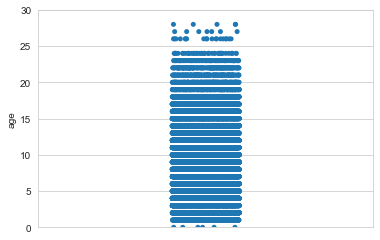

In [13]:
g = sns.stripplot(data = fc , y = 'age', jitter = True)
g.set_ylim([0 , 30])
#sns.plt.show()

#### Time between scheduled and actual appointment
Calcualate the time between the scheduled date and the appoinment date as 'daysbtwn'

In [14]:
#subtracting the dates in between 
fc['daysbtwn'] = fc['appt_date_time'].sub(fc['schedule_date_time'], axis=0)
# converting that into days
fc['daysbtwn'] = round((fc['daysbtwn'] / np.timedelta64(1, 'D')).abs(), 0)


(0, 130)

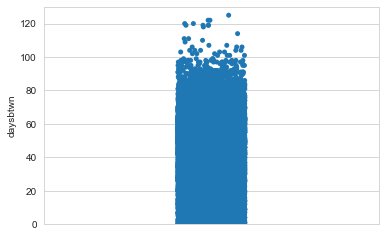

In [15]:
g = sns.stripplot(data = fc , y = 'daysbtwn', jitter = True)
g.set_ylim([0 , 130])
#sns.plt.show()

(0, 19)

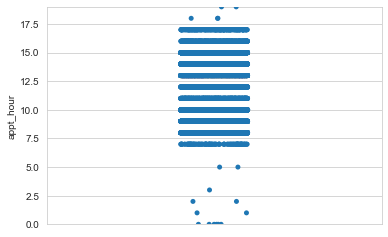

In [16]:
g = sns.stripplot(data = fc , y = 'appt_hour', jitter = True)
g.set_ylim([0 , 19])
#sns.plt.show()

Because the data gets sparse with larger daysbetween and age, we'll set cutoffs

In [17]:
fc = fc[(fc['daysbtwn'] >  1)]
fc = fc[(fc['daysbtwn'] < 150)]

fc = fc[(fc['age'] < 20)]
fc = fc[(fc['age'] > 1)]
fc = fc[(fc['age_mnths'] > 12)]

fc = fc[(fc['appt_hour'] < 17  )]
fc = fc[(fc['appt_hour'] > 7  )]

#### Number of Appointments Cancelled in the Past 
Creating the number cancelled, total appointments, and risk scores for each patientid.

In [18]:
#group by patient id and by cancelled appointments
fc['n_cancelled'] =fc.groupby(['patientid'])['apptslotstatus'].transform('sum')
fc['total_appointment'] = fc.groupby(['patientid'])['apptslotstatus'].transform('count')
fc['risk_score'] = fc['n_cancelled'] / fc['total_appointment']
fc.head()

,patientid,apptyear,apptmnth,apptdate,apptstarttime,apptday,apptcancelreason,apptslotstatus,appttype,apptscheduledate,...,rmssn,appt_date_time,schedule_date_time,appt_hour,apptweeknum,scheduleweeknum,daysbtwn,n_cancelled,total_appointment,risk_score
10230,1636.0,2018,12,12/3/2018,10:30 AM,0,NaN,0,Skin Test,10/19/2018,...,NaN,2018-12-03 10:30:00,2018-10-19 10:07:00,10,49,42.0,45.0,0,1,0.0
10231,1133.0,2019,8,8/20/2019,9:50 AM,1,NaN,0,Blood Draw,7/15/2019,...,8/29/2018,2019-08-20 09:50:00,2019-07-15 11:13:00,9,34,29.0,36.0,0,6,0.0
10232,1133.0,2019,10,10/9/2019,8:15 AM,2,NaN,0,Skin Test,8/16/2019,...,8/29/2018,2019-10-09 08:15:00,2019-08-16 08:45:00,8,41,33.0,54.0,0,6,0.0
10233,1133.0,2019,10,10/9/2019,9:00 AM,2,NaN,0,Food Challenge,8/16/2019,...,8/29/2018,2019-10-09 09:00:00,2019-08-16 08:41:00,9,41,33.0,54.0,0,6,0.0
10234,1133.0,2020,10,10/28/2020,3:15 PM,2,NaN,0,Remission Annual,8/12/2020,...,8/29/2018,2020-10-28 15:15:00,2020-08-12 09:40:00,15,44,33.0,77.0,0,6,0.0


(0, 1)

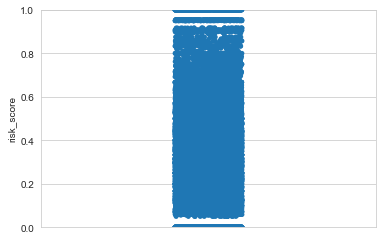

In [19]:
g = sns.stripplot(data = fc , y = 'risk_score', jitter = True)
g.set_ylim([0 , 1])



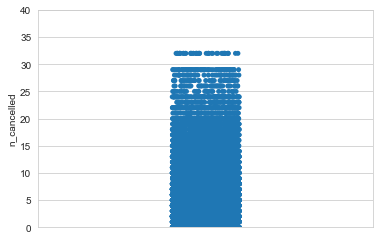

In [20]:
g = sns.stripplot(data = fc , y = 'n_cancelled', jitter = True)
g.set_ylim([0 , 40])
fc = fc[(fc['n_cancelled'] < 40  )]

(0, 50)

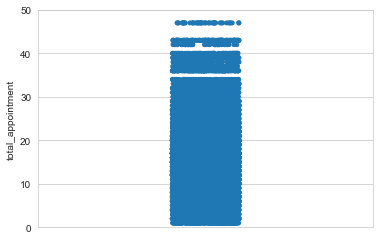

In [21]:
g = sns.stripplot(data = fc , y = 'total_appointment', jitter = True)
g.set_ylim([0 , 50])

## Section 2: Exploring the Data <a class="anchor" id="Section2"></a>

### Exploratory Analysis on Features

The appttypes need to be cleaned because there seems to be variations of the same appttype. I decided to narrow them down to *Food Challenge*, *Onboarding*, and *remssion* to make things more simple.

In [22]:
# Replacing Food Challenge variations to just call it food challenge
fc['appttype'].replace("Food Challenge Zone 1 (1c)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1 (1c1i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1 (1c2i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1 (2c)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1 (2c1i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1(1i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1(2i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1 (2C)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1(3C)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 1(3i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (1c)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (1c1i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (1c2i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (1i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (2c)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (2c1i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (2i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (3c)", "Food Challenge", inplace = True)
fc['appttype'].replace("Food Challenge Zone 2/3 (3i)", "Food Challenge", inplace = True)
fc['appttype'].replace("Tolerance Visit 1", "Food Challenge", inplace = True)
fc['appttype'].replace("Tolerance Visit 2", "Food Challenge", inplace = True)
fc['appttype'].replace("Zone 2/Zone 3", "Food Challenge", inplace = True)
fc['appttype'].replace("Launch Visit", "Food Challenge", inplace = True)
fc['appttype'].replace("Repeat Challenge", "Food Challenge", inplace = True)

fc['appttype'].replace("Skin Test", "Onboarding", inplace = True)
fc['appttype'].replace("Blood Draw","Onboarding", inplace = True)
fc['appttype'].replace("Patch Placement", "Onboarding", inplace = True)
fc['appttype'].replace("Pulmonary Follow Up", "Onboarding", inplace = True)

fc['appttype'].replace("Onboarding Visit", "Onboarding", inplace = True)
fc['appttype'].replace("Onboarding Lab", "Onboarding", inplace = True)


fc['appttype'].replace("Post Remission Food Challenge", "Remission", inplace = True)
fc['appttype'].replace("Remission Call", "Remission", inplace = True)
fc['appttype'].replace("Remission Visit 1", "Remission", inplace = True)
fc['appttype'].replace("Remission Annual", "Remission", inplace = True)
fc['appttype'].replace("Remission Lab", "Remission", inplace = True)


fc['apptcancelreason'].fillna("Filled", inplace = True)

Next, we'll see how each features weigh in on the apptslotstatus being cancelled. 

In [23]:
# finding the average cancellations
fc['apptslotstatus'].mean()

0.34372347448835233

In [24]:
# finding out how each feature weighs in on the apptslotstatus being cancelled
features = [ 'appttype','apptmnth','apptweeknum', 'appt_hour', 'apptday', 'zn1', 'zn2', 'zn3', 'age', 
       'call', 'text', 'daysbtwn', 'appt_hour','prvdr', 'risk_score', 'apptcancelreason', 'insurance', 'rmssn']
for i in features:
    print(fc.groupby(i)['apptslotstatus'].mean())

appttype
Food Challenge    0.343816
Onboarding        0.347413
Remission         0.262436
Name: apptslotstatus, dtype: float64
apptmnth
1     0.303053
2     0.321333
3     0.499372
4     0.556126
5     0.381780
6     0.309761
7     0.321326
8     0.334714
9     0.307492
10    0.340291
11    0.241551
12    0.248594
Name: apptslotstatus, dtype: float64
apptweeknum
1     0.318052
2     0.261618
3     0.325383
4     0.264657
5     0.337942
6     0.287375
7     0.317109
8     0.361240
9     0.322157
10    0.326121
11    0.356835
12    0.593830
13    0.640584
14    0.584286
15    0.567931
16    0.593701
17    0.542138
18    0.499374
19    0.392593
20    0.367560
21    0.382597
22    0.375602
23    0.303426
24    0.293375
25    0.296754
26    0.323630
27    0.339670
28    0.340984
29    0.320961
30    0.352941
31    0.272316
32    0.314991
33    0.296627
34    0.363839
35    0.362734
36    0.306846
37    0.290657
38    0.320526
39    0.307828
40    0.370279
41    0.343053
42    0.300877
43   

### 2.1: Numerical Features <a class="anchor" id="Section2.1"></a>

In [25]:
def prob( x, y):
    df = pd.crosstab( index = x[y] , columns = x['apptslotstatus']).reset_index()
    df['fulfilled'] = df[0] / (df[1] + df[0])
    return df[[y, 'fulfilled']]

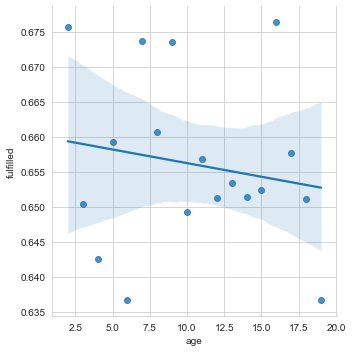

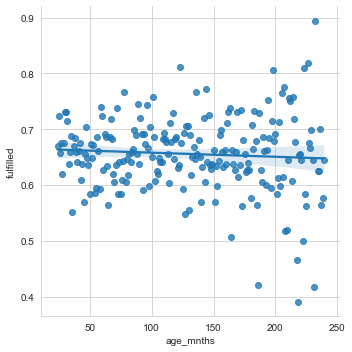

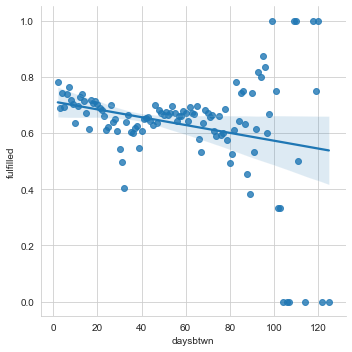

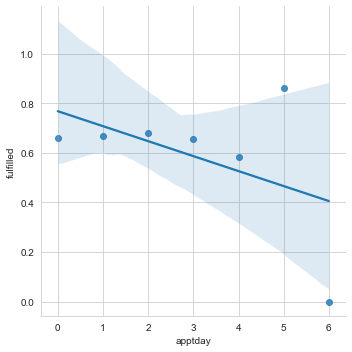

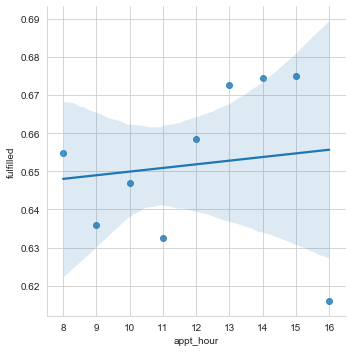

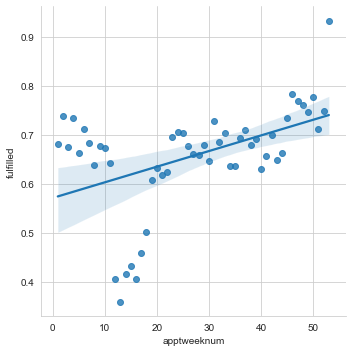

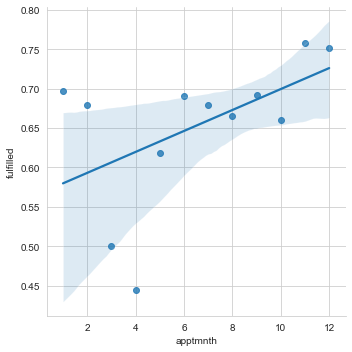

In [26]:
sns.lmplot( x = 'age', y = 'fulfilled',  data = prob(fc, 'age'), fit_reg = True)
sns.lmplot( x = 'age_mnths', y = 'fulfilled', data = prob(fc, 'age_mnths'), fit_reg = True)
sns.lmplot( x = 'daysbtwn', y = 'fulfilled', data = prob(fc, 'daysbtwn'), fit_reg = True)
sns.lmplot( x = 'apptday', y = 'fulfilled', data = prob(fc, 'apptday'), fit_reg = True)
sns.lmplot( x = 'appt_hour', y = 'fulfilled', data = prob(fc, 'appt_hour'), fit_reg = True)
sns.lmplot( x = 'apptweeknum', y = 'fulfilled', data = prob(fc, 'apptweeknum'), fit_reg = True)
sns.lmplot( x = 'apptmnth', y = 'fulfilled', data = prob(fc, 'apptmnth'), fit_reg = True)


In [27]:
#fc = fc[(fc['daysbtwn'] < 100  )]
fc = fc[(fc['daysbtwn'] != 32  )]
fc = fc[(fc['daysbtwn'] != 119  )]

fc = fc[(fc['apptweeknum'] != 119  )]

fc = fc[(fc['appt_hour'] != 16)]

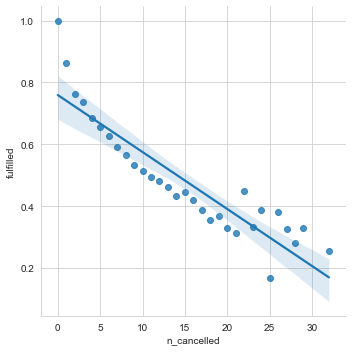

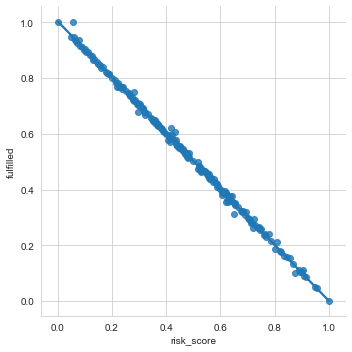

In [28]:
sns.lmplot( x = 'n_cancelled', y = 'fulfilled', data = prob(fc,'n_cancelled'), fit_reg = True)
sns.lmplot( x = 'risk_score', y = 'fulfilled', data = prob(fc,'risk_score'), fit_reg = True)

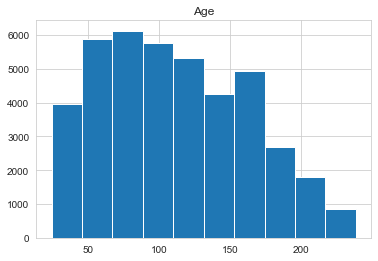

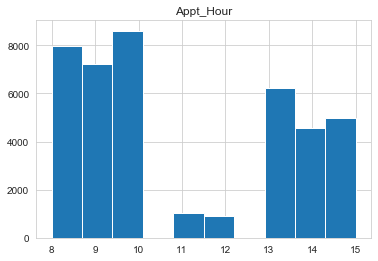

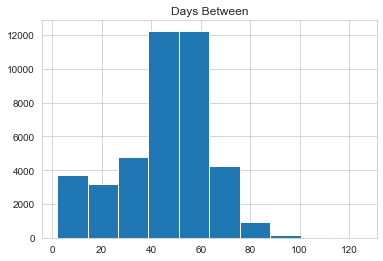

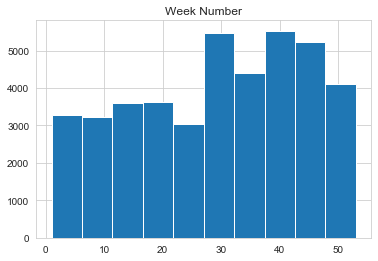

In [29]:
plt.hist(fc['age_mnths'])
plt.title('Age')
plt.show()
plt.hist(fc['appt_hour'])
plt.title('Appt_Hour')
plt.show()
plt.hist(fc['daysbtwn'])
plt.title('Days Between')
plt.show()
plt.hist(fc['apptweeknum'])
plt.title('Week Number')
plt.show()

Possible outliers in days between. Let's work on identifying and removing them. 

### 2.2: Categorical Features <a class="anchor" id="Section2.2"></a>

In [30]:
def probcat(group_by):
    rows = []
    for item in group_by:
        for level in fc[item].unique():
            row = {'Condition': item}
            total = len(fc[fc[item] == level])
            n = len(fc[(fc[item] == level) & (fc['apptslotstatus'] == 0)])
            row.update({'Level': level, 'Probability': n / total})
            rows.append(row)
        return pd.DataFrame(rows)

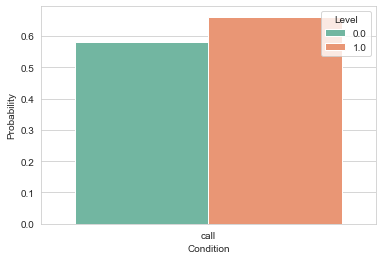

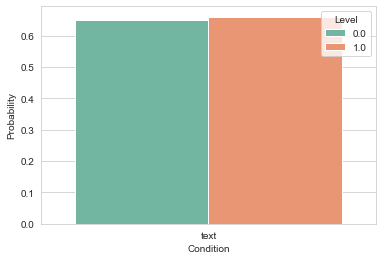

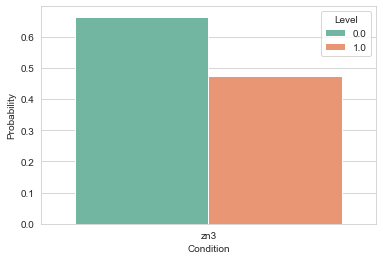

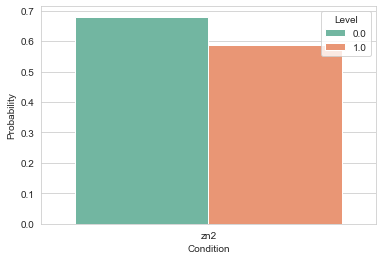

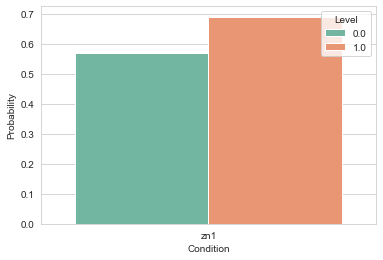

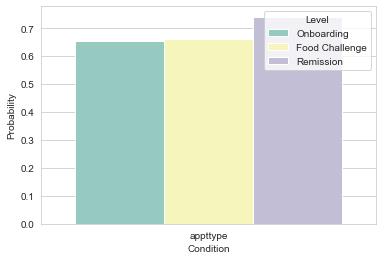

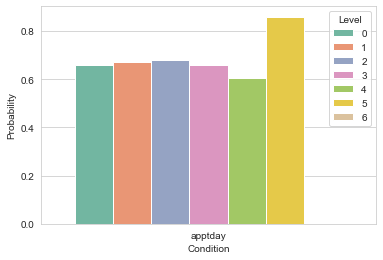

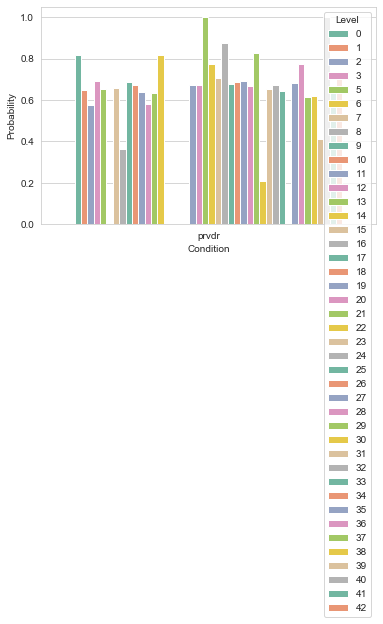

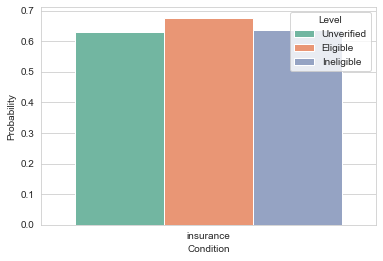

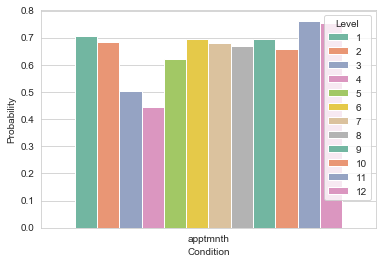

In [31]:
#probability of showing up to appointment 
sns.barplot(data = probcat(['call']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['text']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['zn3']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['zn2']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['zn1']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['appttype']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set3')
plt.show()
sns.barplot(data = probcat(['apptday']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['prvdr']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()
sns.barplot(data = probcat(['insurance']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()

sns.barplot(data = probcat(['apptmnth']), x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.show()

In [32]:
fc = fc[(fc['apptmnth'] != 3)]
fc = fc[(fc['apptmnth'] != 4)]

In [33]:
#encoding appointment type 
fc['appttype_encoded'] = LabelEncoder().fit_transform(fc['appttype'])
fc['ins_encoded'] = LabelEncoder().fit_transform(fc['insurance'])
fc['can_encoded'] = LabelEncoder().fit_transform(fc['apptcancelreason'])


## Part 3: Modeling Building <a class="anchor" id="Section3"></a>

### Training Set

We'll use a train dataset to fir the ml model and test dataset to evaluate the fir machine learning model. 

In [34]:
#training set
X = fc[['apptyear','apptmnth','appt_hour','appttype_encoded','apptday','apptweeknum', 'zn1', 'zn2', 'zn3', 'call', 'risk_score',  'ins_encoded', 'scheduleweeknum','daysbtwn']]
#X = fc[[ 'risk_score', 'n_cancelled']]

#X = fc[['apptyear','apptmnth', 'appt_hour','appttype_encoded','apptday','apptweeknum', 'zn1', 'zn2', 'zn3', 'age','age_mnths', 'call', 'text', 'risk_score', 'n_cancelled', 'total_appointment', 'ins_encoded', 'prvdr_encoded','scheduleweeknum','daysbtwn', 'id_encoded']]
y = fc['apptslotstatus']


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.20)
#from sklearn.model_selection import TimeSeriesSplit

#tss = TimeSeriesSplit(n_splits = 3 )

#for train_index, test_index in tss.split(X):
#    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

### Prediction

In [36]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.71593533 0.71362587 0.71695096 0.7061123  0.71162047]
0.7128489850319502


In [37]:
lr = LogisticRegression(max_iter = 53000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.74098419 0.72535086 0.72743426 0.73347548 0.72423596]
0.7302961501403472


In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28142, 14) (7036, 14) (28142,) (7036,)


In [39]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.70811867 0.68484633 0.695629   0.70095949 0.69651741]
0.697214180348164


In [40]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.68573459 0.67738497 0.69083156 0.6862118  0.68869936]
0.685772454884171


In [41]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.7669213  0.75128797 0.75088842 0.75817342 0.75604122]
0.7566624659106822


In [42]:
from sklearn.metrics import mean_absolute_error
rf.fit(X_train, y_train)
yhat = rf.predict(X_test).astype(int)

mae= mean_absolute_error(y_test, yhat)
print ( 'MAE: %3f' %mae)
# MAE < 10% excellent 
# MAE < 20% Good 


MAE: 0.244741


In [43]:
#Predicting on entire dataset
yhat2 = rf.predict(X)
fc['yhat2'] = yhat2

In [44]:
fc.to_csv('cancellation_prediction.csv', index = False)

In [45]:
fc.head(50)

,patientid,apptyear,apptmnth,apptdate,apptstarttime,apptday,apptcancelreason,apptslotstatus,appttype,apptscheduledate,...,apptweeknum,scheduleweeknum,daysbtwn,n_cancelled,total_appointment,risk_score,appttype_encoded,ins_encoded,can_encoded,yhat2
10230,1636.0,2018,12,12/3/2018,10:30 AM,0,Filled,0,Onboarding,10/19/2018,...,49,42.0,45.0,0,1,0.000000,1,2,2,0
10231,1133.0,2019,8,8/20/2019,9:50 AM,1,Filled,0,Onboarding,7/15/2019,...,34,29.0,36.0,0,6,0.000000,1,0,2,0
10232,1133.0,2019,10,10/9/2019,8:15 AM,2,Filled,0,Onboarding,8/16/2019,...,41,33.0,54.0,0,6,0.000000,1,0,2,0
10233,1133.0,2019,10,10/9/2019,9:00 AM,2,Filled,0,Food Challenge,8/16/2019,...,41,33.0,54.0,0,6,0.000000,0,0,2,0
10234,1133.0,2020,10,10/28/2020,3:15 PM,2,Filled,0,Remission,8/12/2020,...,44,33.0,77.0,0,6,0.000000,2,0,2,0
10235,1133.0,2020,9,9/9/2020,3:30 PM,2,Filled,0,Onboarding,8/12/2020,...,37,33.0,28.0,0,6,0.000000,1,0,2,0
10237,785.0,2018,6,6/21/2018,9:00 AM,3,Filled,0,Onboarding,5/7/2018,...,25,19.0,45.0,5,18,0.277778,1,2,2,0
10238,785.0,2018,6,6/22/2018,9:00 AM,4,Filled,0,Food Challenge,5/7/2018,...,25,19.0,46.0,5,18,0.277778,0,2,2,0
10239,785.0,2019,8,8/14/2019,10:00 AM,2,Filled,0,Food Challenge,6/26/2019,...,33,26.0,49.0,5,18,0.277778,0,1,2,0
10240,785.0,2019,12,12/3/2019,10:00 AM,1,PATIENT RESCHEDULED,1,Food Challenge,11/26/2019,...,49,48.0,7.0,5,18,0.277778,0,1,13,1


## Reflection <a class="anchor" id="Section4"></a>

The Random Forest model yielded an accuracy of 75%. Some limitations of this dataset is the lack of consistancy in the appttypes. There were many apptypes that had to be narrowed down into categories and may have been too generalized on the weight of cancelled appointments. I would also note that I removed dates in March, June, and July since COVID-19 effected the cancellations, it would also have effected the accuracy. It's possible that the appointment cancellation predictions would be more accurate had times been more normal. 